In [2]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as plt


import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

##################
from tqdm import tqdm, trange
#from tqdm.notebook import tqdm googlecolab
import tensorflow as tf 

#from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Bidirectional,GRU
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [6]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))
###計算Rmse
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, single_step=False):
  data = []
  labels = []
  
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
  
  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(dataset[indices])
    
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])
  
  return np.array(data), np.array(labels)


def lstm_model2(input_length, input_dim):

    d=0.3
    model= Sequential()
    model.add(LSTM(256,input_shape=(input_length, input_dim),return_sequences=True))
    model.add(Dropout(d))

    model.add(LSTM(128,input_shape=(input_length, input_dim),return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(16,activation='linear'))#linear / softmax(多分類) / sigmoid(二分法)
    model.add(Dropout(d))

    model.add(Dense(1,activation='linear'))#linear / softmax(多分類) / sigmoid(二分法)

    # optimizer = tf.keras.optimizers.Adam(lr=0.00005)
    model.compile(loss='mse',optimizer='adam')#loss=mse/categorical_crossentropy

    return model 

In [7]:
dataset_train = pd.read_csv("data/0050.csv")
x = dataset_train.iloc[:,2:].values
y = dataset_train["Close"]


In [8]:
scaler=MinMaxScaler(feature_range=(0,1))
y=scaler.fit_transform(y.to_frame())
scaler1=MinMaxScaler(feature_range=(0,1))
x=scaler1.fit_transform(x)

In [9]:
x,y=multivariate_data( x ,y , 0 ,None, 10 , 1 ,single_step=True)
split =0.95
x_,y_  = x[0:int(split*len(x))] , y[0:int(split*len(x))]
x_test ,y_test   = x[int(split*len(x)):] , y[int(split*len(x)):]
split= 0.8
x_train,y_train  =x_[:int(split*len(x_))] , y_[:int(split*len(x_))]
x_vaild,y_vaild  =x_[int(split*len(x_)):] , y_[int(split*len(x_)):]

In [10]:
trainindex= dataset_train.index[10:len(x_train)+10]
valindex = dataset_train.index[len(x_train)+10:len(x_train)+10+len(x_vaild)]

In [11]:
print(x_train.shape,y_train.shape,x_vaild.shape,y_vaild.shape,)

(728, 10, 8) (728, 1) (182, 10, 8) (182, 1)


In [13]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=300, monitor = 'val_loss')
    ]
filepath="lstm.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min',save_best_only=True)

call_backlist = [ my_callbacks,checkpoint]
callbacks=call_backlist
lstm2 = lstm_model2(10,8)
historylstm2 = lstm2.fit( x_train, y_train, batch_size=30,shuffle=False , epochs=1000,validation_data=(x_vaild,y_vaild),callbacks=call_backlist)
lstm2.summary()

Epoch 1/1000


2024-04-23 22:58:52.072288: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-04-23 22:58:53.878110: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1f7eb870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-23 22:58:53.878145: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-04-23 22:58:53.883445: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-23 22:58:53.980614: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-23 22:58:54.284604: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/25 [===========================>..] - ETA: 0s - loss: 0.0246 
Epoch 1: val_loss improved from inf to 0.01502, saving model to lstm.best.hdf5
25/25 [==============================] - 16s 28ms/step - loss: 0.0245 - val_loss: 0.0150
Epoch 2/1000
23/25 [==========================>...] - ETA: 0s - loss: 0.0296
Epoch 2: val_loss improved from 0.01502 to 0.00352, saving model to lstm.best.hdf5


/home/yuyu/anaconda3/envs/ai_car/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 0s 8ms/step - loss: 0.0284 - val_loss: 0.0035
Epoch 3/1000
21/25 [========================>.....] - ETA: 0s - loss: 0.0138
Epoch 3: val_loss did not improve from 0.00352
25/25 [==============================] - 0s 6ms/step - loss: 0.0139 - val_loss: 0.0075
Epoch 4/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.0128
Epoch 4: val_loss did not improve from 0.00352
25/25 [==============================] - 0s 6ms/step - loss: 0.0128 - val_loss: 0.0152
Epoch 5/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.0138
Epoch 5: val_loss did not improve from 0.00352
25/25 [==============================] - 0s 6ms/step - loss: 0.0138 - val_loss: 0.0236
Epoch 6/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.0160
Epoch 6: val_loss did not improve from 0.00352
25/25 [==============================] - 0s 6ms/step - loss: 0.0160 - val_loss: 0.0218
Epoch 7/1000
25/25 [==============================] - ETA: 0s - loss:

2/2 [==============================] - 0s 4ms/step


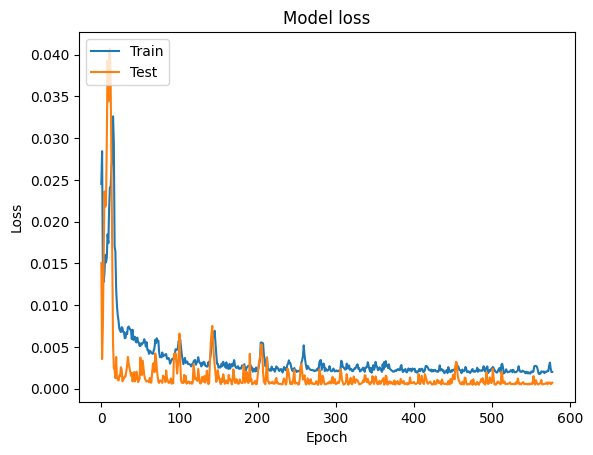

6/6 [==============================] - 0s 2ms/step


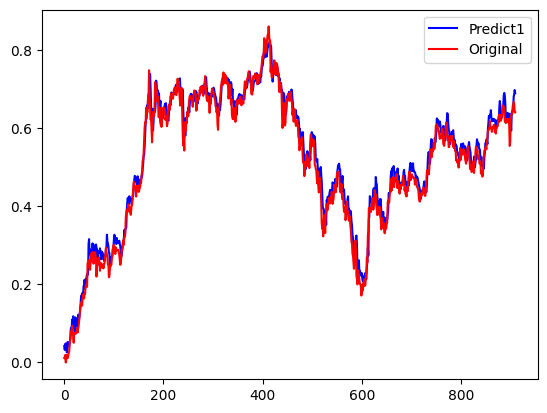

2/2 [==============================] - 0s 3ms/step


/home/yuyu/anaconda3/envs/ai_car/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yuyu/anaconda3/envs/ai_car/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20729 (\N{CJK UNIFIED IDEOGRAPH-50F9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


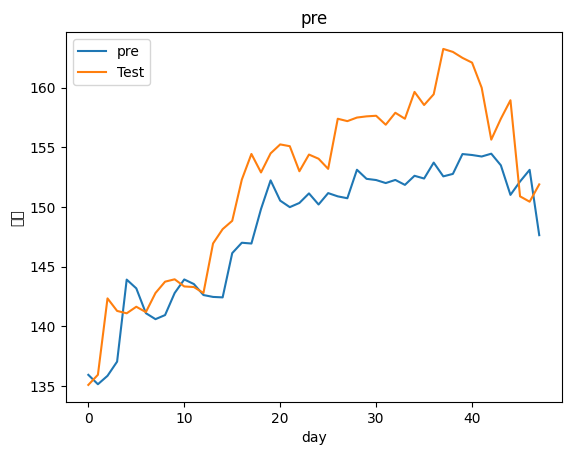

4.954743899774919

In [15]:
import matplotlib.pyplot as plt

lstm1train  = lstm2.predict(x_train)
lstm1val = lstm2.predict(x_vaild)
lstm1pre = lstm2.predict(x_test)
plt.plot(historylstm2.history['loss'])
plt.plot(historylstm2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

pre = lstm2.predict(x_train)
pre1=lstm2.predict(x_vaild)
fc=np.concatenate((pre,pre1))
yreal=np.concatenate((y_train,y_vaild))
plt.figure(facecolor='white')
pd.Series(fc.reshape(-1)).plot(color='blue', label='Predict1')
pd.Series(yreal.reshape(-1)).plot(color='red', label='Original')

plt.legend()
plt.show()
lstm1pre = lstm2.predict(x_test)
pre= scaler.inverse_transform(lstm1pre)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

plt.figure()
plt.plot(pre)
plt.plot(y_test)
plt.title('pre')
plt.ylabel('股價')
plt.xlabel('day')
plt.legend(['pre', 'Test'], loc='upper left')
plt.show()

root_mean_squared_error(pre,y_test) 